In [65]:
import modules.ident as ident
import cv2
from matplotlib import pyplot as plt
import numpy as np
import ipywidgets as widgets
import modules.helpers as h
import glob
import os
from IPython.display import Image as IPyImage
from matplotlib.patches import Circle
from skimage import draw
from scipy.signal import find_peaks
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets.widgets import FloatSlider, IntSlider
from lmfit import Model
import matplotlib.gridspec as gridspec
import json


%matplotlib ipympl
plt.style.use(['seaborn-paper','science'])
plt.ioff()

In [2]:
data_folder = 'data'
# h.list_files(data_folder)

In [3]:
SeeAllFiles = True

In [353]:
sub_dir = './data/oct8/second'
sci_peak_data_dir = sub_dir+os.sep+"sci_peak_data"
pickle_dir = sub_dir+os.sep+"obj"
fit_dir = sub_dir + os.sep + "fit_result"

all_files = glob.glob(f"{sub_dir+os.sep}[!C_]*.JPG") ## Use regex to avoid C_ files

if SeeAllFiles == True:
    Ofiles = all_files
else:
    Ofiles = [f for f in all_files if os.path.basename(f).replace("JPG",'pkl') not in os.listdir(pickle_dir)]
    
f = lambda x: IPyImage(filename = x,width = 400, height = 200)
wi = widgets.interact(f, x = Ofiles)

interactive(children=(Dropdown(description='x', options=('./data/oct8/second/30_4.JPG', './data/oct8/second/9_…

### Imported pre-processed data

In [504]:
fname = wi.widget.kwargs['x']
f_string = os.path.basename(fname)
name = f_string.replace(".JPG","")
data_dict = h.load_obj(name, pickle_dir)
x = np.load(sci_peak_data_dir+os.sep+name+'_dist.npy')
y = np.load(sci_peak_data_dir+os.sep+name+'_data.npy')
yerr = np.sqrt(y)
yerr = np.where(yerr==0, 1, yerr) 

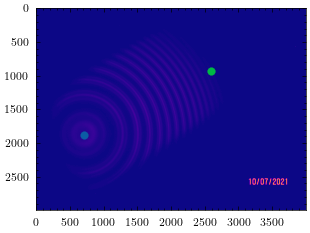

In [505]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
im = cv2.imread(fname).astype(np.float32)
ax.imshow(im[:,:,-1],cmap = 'plasma')
ax.scatter(*data_dict['p1'])
ax.scatter(*data_dict['p2'])
plt.show()

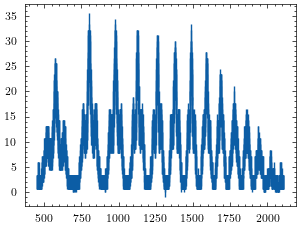

In [506]:
plt.close()
plt.figure()
plt.errorbar(x,y, yerr, ls = '')
plt.show()

#### Define relevant functions for the fit. Use three gaussians and see if they converge

In [507]:
gaussian = lambda x,m,A,s: A*np.exp(-(x-m)**2/(2*s)**2)
fit_f = lambda x, dx,m0,A0,A1,s0,s1,a,b: gaussian(x,m0-dx,A1,s1)\
    + gaussian(x,m0,A0,s0) + gaussian(x,m0+dx,A1,s1) + a*x+b

## Use. 0 to indicate the center peak

## Fitting peaks in the figure

In [534]:
idx = 2

left = data_dict[idx][0]; center = data_dict[idx][1]; right = data_dict[idx][2]+10;

plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

sel = np.logical_and(x>left,x<right)
x_fit = x[sel]; y_fit = y[sel]; yerr_fit = yerr[sel];

def guess(dx,m0,A0,A1,s0,s1,a,b):
    global _lines2
    line1 = ax.plot(x_fit,y_fit,'bo', ms = 2)
    _x = np.linspace(left,right,50);
    _y = fit_f(_x,dx,m0,A0,A1,s0,s1,a,b)
    try:
        ax.lines.remove(_lines2[0])
    except:
        pass
    _lines2 = ax.plot(_x,_y,'k--')
    fig.show()

## Import from previous set values    
try:
    dx = data_dict[f'w{idx}']['dx'];     m0 = data_dict[f'w{idx}']['m0'];     A0 = data_dict[f'w{idx}']['A0'];
    A1 = data_dict[f'w{idx}']['A1'];     s0 = data_dict[f'w{idx}']['s0'];     s1 = data_dict[f'w{idx}']['s1'];
    
    a = data_dict[f'w{idx}']['a'];     b = data_dict[f'w{idx}']['b'];   
    
except KeyError:
    dx = 20; m0 = center; A0 = 20; A1 = 10; s0 = 8; s1 = 8; a= 0;b=2;
    
w = interactive(guess,
 dx = FloatSlider(value = dx, description='dx', max=100, min=0, step=3.0),
 m0 = FloatSlider(value = m0, description='m0', max=center + 20, min=center - 20, step=3.0),
 A0 = IntSlider(value = A0, description='A0', max=60, min=-20),
 A1 = IntSlider(value = A1, description='A1', max=90, min=-30),
 s0 = FloatSlider(value = s0, description='s0', max=20, min=0),
 s1 = FloatSlider(value = s1, description='s1', max=20, min=0),
 a = FloatSlider(value = a, description='a', max=5, min=-5),
 b = FloatSlider(value = b, description='b', max=2, min=0))

w

interactive(children=(FloatSlider(value=20.0, description='dx', step=3.0), FloatSlider(value=977.1719398345411…

#### Export the guess parameters to dictionary for reusability

In [535]:
data_dict[f'w{idx}'] = w.kwargs
h.save_obj(data_dict,name,pickle_dir)

In [536]:
gmodel = Model(fit_f)
print('parameter names: {}'.format(gmodel.param_names))
print('independent variables: {}'.format(gmodel.independent_vars))
params = gmodel.make_params(**w.kwargs)
params['b'].min = 0; params['dx'].max =60; params['dx'].min = 0

parameter names: ['dx', 'm0', 'A0', 'A1', 's0', 's1', 'a', 'b']
independent variables: ['x']


In [537]:
result = gmodel.fit(y_fit,params, x = x_fit, weights = 1/yerr_fit**2)
try:
    os.mkdir(fit_dir)
except FileExistsError:
    pass

with open(fit_dir+os.sep+ name+f"_{idx}" , 'w+') as f:
    result.params.dump(f)

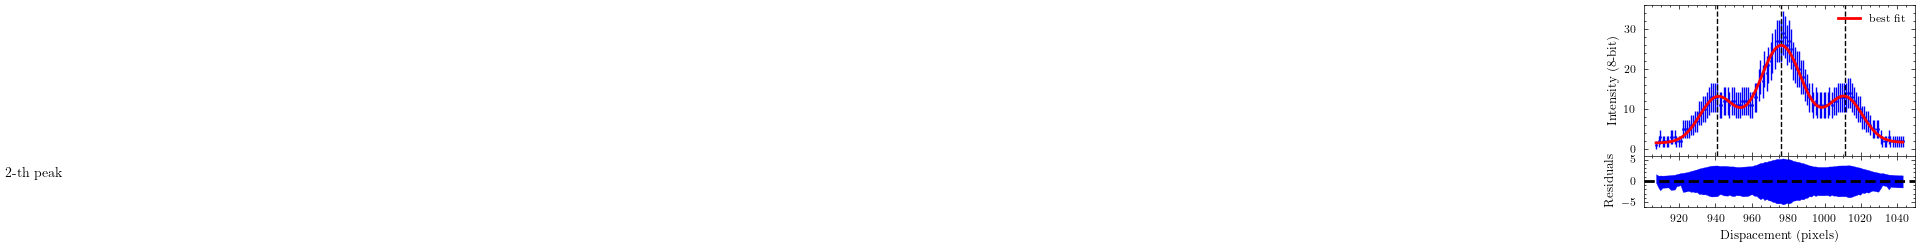

In [538]:
fig = plt.figure()
spec2 = gridspec.GridSpec(ncols=1, nrows=4, figure=fig)
ax1 = fig.add_subplot(spec2[:-1, :])
ax2 = fig.add_subplot(spec2[-1, :])
fig.subplots_adjust(wspace=0, hspace=0)

ax1.errorbar(x_fit,y_fit,yerr = yerr_fit, fmt='bo',ms = 2,zorder = 0)
# plt.plot(x_fit, result.init_fit, 'k--', label='initial fit')
ax1.axvline(x = result.best_values['m0'], ls = '--', c= 'k')
ax1.axvline(x = result.best_values['m0']-result.best_values['dx'], ls = '--', c= 'k')
ax1.axvline(x = result.best_values['m0']+result.best_values['dx'], ls = '--', c= 'k')
ax1.plot(x_fit, result.best_fit, 'r-', label='best fit',lw = 2)
ax1.legend(loc='best')
ax1.set_ylabel('Intensity (8-bit)')

ax2.fill_between(x_fit, result.residual-yerr_fit, result.residual + yerr_fit, color='blue')
ax2.axhline(y = 0,ls= '--',c= 'k',lw = 2,zorder =2)
ax2.set_xlabel('Dispacement (pixels)')
ax2.set_ylabel('Residuals')
ax2.text(0.1,0.9,f"{idx}-th peak")
fig.show()

try:
    os.mkdir(f'figures/{name}')

except FileExistsError:
    pass
plt.savefig(f"figures/{name}/{idx}_peak.pdf",format = 'pdf', bbox_inches = 'tight')


In [539]:
print(result.fit_report())

[[Model]]
    Model(<lambda>)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 84
    # data points      = 122
    # variables        = 8
    chi-square         = 2.51756983
    reduced chi-square = 0.02208395
    Akaike info crit   = -457.448689
    Bayesian info crit = -435.016521
[[Variables]]
    dx:  35.0632631 +/- 0.64705680 (1.85%) (init = 20)
    m0:  976.100321 +/- 0.27760819 (0.03%) (init = 977.1719)
    A0:  24.2656173 +/- 1.07419398 (4.43%) (init = 20)
    A1:  11.2791804 +/- 0.40315907 (3.57%) (init = 10)
    s0:  8.35349001 +/- 0.48314042 (5.78%) (init = 8)
    s1:  6.81831080 +/- 0.31362439 (4.60%) (init = 8)
    a:   0.00118587 +/- 0.00109693 (92.50%) (init = 0)
    b:   0.48287180 +/- 1.05238506 (217.94%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b)   = -0.997
    C(dx, s0) =  0.837
    C(dx, s1) = -0.799
    C(s0, s1) = -0.709
    C(A0, s0) = -0.697
    C(m0, a)  = -0.508
    C(m0, b)  =  0.506
    C(A1, s0)